# Public Sentiment toward NVIDIA RTX 5000 Series vs. AMD RX 9000 Series GPU Launches

## Overview
- **Goal:** Analyze and compare public sentiment on recent NVIDIA/AMD GPU launches using YouTube comments and tech news.
- **Pipeline:** Data collection → Pre-processing → Entity/sentiment tagging → Analysis → Visualization.


## Research Questions
1. What is the overall public sentiment surrounding NVIDIA’s RTX 5000 and AMD’s RX 9000 series releases?
2. Are there noticeable differences online in how consumers percieve NVIDIA versus AMD GPUs?
3. Which specific features or technologies generate the strongest positive or negative sentiment among users?
4. How frequently and in what context are specific GPU products and technologies (DLSS, Ray Tracing, FSR, Frame Generation) mentioned in online discussions?


Full code and figures: [github.com/intox1ca7ed/NLP-project](https://github.com/intox1ca7ed/NLP-project); this notebook generates all assets used in the accompanying 20-page report.


# Setup

In [3]:
import sys
import glob
import json
import ast
import re
import html
import unicodedata
import langdetect
import platform
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import spacy
import importlib.util

from itertools import combinations
from collections import Counter
from pathlib import Path
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from spacy.matcher import PhraseMatcher
from langdetect import detect, DetectorFactory
from wordcloud import WordCloud
from tqdm import tqdm   

#spacy'y language model
if not importlib.util.find_spec("en_core_web_sm"):
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

RANDOM_STATE = 44

# base directory & path to get rid of hard-pathing
import os
BASE_DIR = os.getcwd()
RAW_DATA_PATH = os.path.join(BASE_DIR, "data-raw")
PROCESSED_DATA_PATH = os.path.join(BASE_DIR, "data-processed")
IMG_PATH = os.path.join(BASE_DIR, "img")

plt.rcParams["savefig.directory"] = "images"
plt.rcParams["savefig.dpi"] = 300

# Data Collection

In this section, we collect raw textual data relevant to recent GPU launches by NVIDIA and AMD from two main sources: YouTube video comments and online tech-news articles. The aim is to capture a diverse, organic cross-section of public sentiment from both enthusiast communities and professional media.


## Youtube Comments

To analyze public sentiment toward each major GPU model, I manually assembled a dataset of 72 YouTube videos focused on recent NVIDIA and AMD graphics card launches. Our selection includes:

- **NVIDIA**: 6 distinct RTX 50xx models (RTX 5090, RTX 5080, RTX 5070 Ti, RTX 5070, RTX 5060 Ti, RTX 5060), with exactly 8 videos per model (totaling 48 videos).

- **AMD**: 2 models from the RX 9000 family (RX 9070, RX 9070 XT), with a combined 24 videos (covering both models).

Each video was chosen to maximize topical relevance, covering official launches, reviews, benchmarks, and community discussions. All video metadata—brand, model, video title, and URL—was logged in `gpu-list-links.csv`.

In [4]:
manifest = pd.read_csv("gpu-list-links.csv")
print("Videos per Brand:")
display(manifest['Brand'].value_counts())
print("Videos per GPU Model:")
display(manifest['GPU Model'].value_counts())

Videos per Brand:


Brand
NVIDIA    48
AMD       24
Name: count, dtype: int64

Videos per GPU Model:


GPU Model
RX 9070 XT     17
RTX 5060        8
RTX 5070        8
RTX 5060 Ti     8
RTX 5070Ti      8
RTX 5080        8
RTX 5090        8
RX 9070         7
Name: count, dtype: int64

For comment collection, I used `yt-dlp` to download all publicly available comments from each selected video. First, I ran a Python script (generate-yt-commands.py) that read our gpu-list-links.csv and produced a batch file (yt-download.bat) containing all the necessary yt-dlp commands for the 72 chosen videos.   
  
Executing this batch file automated the entire comment download process. Each resulting `.comments.json` file is named to include the brand, GPU model, and video ID, making it straightforward to trace each dataset back to its source. With the downloads complete, the raw comment data for all selected videos is ready for parsing and further analysis. 

In [5]:
json_folder = "data-raw/comments json"
all_comments = []

json_files = glob.glob(os.path.join(json_folder, "*.info.json"))
print(f"Found {len(json_files)} info.json files.")

for file in json_files:
    basename = os.path.basename(file)
    # Extract video_id robustly
    video_id = basename.rsplit('_', 1)[-1].replace('.info.json', '')

    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        comments = data.get("comments", [])
        for comment in comments:
            all_comments.append({
                "text": comment.get("text", ""),
                "video_id": video_id,
                "author": comment.get("author", ""),
                "like_count": comment.get("like_count", 0),
                "timestamp": comment.get("timestamp", None),
            })

print(f"Total comments extracted: {len(all_comments)}")
yt_df = pd.DataFrame(all_comments)
yt_df.to_csv("data-raw/yt-comments-raw.csv", index=False)
yt_df.head()

Found 71 info.json files.
Total comments extracted: 187171


text            video_id  \
0  The pricing has officially been set \n9070 at ...  01DEKGYiSTo.(ext)s   
1                             oh hell yeah. amd ftw!  01DEKGYiSTo.(ext)s   
2                   9070XT*, 9070 is displayed twice  01DEKGYiSTo.(ext)s   
3  I will deffo get one. I want that Nitro+ or As...  01DEKGYiSTo.(ext)s   
4  Very impressive from AMD they are not here to ...  01DEKGYiSTo.(ext)s   

                 author  like_count   timestamp  
0         @Jayztwocents        4100  1742860800  
1      @DavidKnowsAudio         130  1742860800  
2  @WilliamJuarez-kx1qg         432  1742860800  
3    @Die_Graue_Eminenz          36  1742860800  
4         @alghasimouba          55  1742860800

Finally, I extracted all user comments from the 72 `.info.json` files. Each .info.json file contains a list of comments in its **"comments"** field.  

Thus, I iterated over all files in the dataset, parsed out each comment’s text, author, like count and timestamp, and recorded the associated YouTube video ID based on the filename. All extracted comments were combined into a single pandas DataFrame and saved as a CSV.

## News Articles

To complement user-generated YouTube comments, I gathered a dataset of 92 English-language news articles from tech media resources. Each article relates to recent launches and reviews of NVIDIA RTX 50xx and AMD RX 9070 GPUs.  

Articles were selected to provide broad and balanced coverage of each new-generation GPU model, including official announcement and reviews. There are 10 articles for each of 8 unique GPU models (80 combined).  
  

To automate the extraction of article content,a Python script iterates through the dataset and scrapes the main text from each article using the `requests` and `BeautifulSoup` libraries.  

Raw data can be seen in `news-articles-scraped.csv` file.











# Pre-processing


## Data Loading and Unification

We begin by loading both the YouTube comments and news articles datasets into pandas DataFrames. To streamline downstream analysis, we standardize the column names and formats, and combine both sources into a single DataFrame. We also add a source column to distinguish comments from articles.

In [6]:
yt_df = pd.read_csv("data-raw/yt-comments-raw.csv")
news_df = pd.read_csv("data-raw/articles-raw.csv")
#I add source column to distinguish between YouTube comments and news articles
yt_df['source'] = "YouTube"
news_df['source'] = "News"

manifest = pd.read_csv("gpu-list-links.csv")  # contains Brand, GPU Model, YouTube URL
manifest["video_id"] = manifest["YouTube URL"].str.extract(r"v=([a-zA-Z0-9_-]{11})")
yt_merged = yt_df.merge(manifest[["video_id", "Brand", "GPU Model"]], on="video_id", how="left")

yt_clean = yt_merged[['text', 'source', 'video_id', 'author', 'like_count', 'timestamp', 'Brand', 'GPU Model']]
yt_clean = yt_clean.rename(columns={'Brand': 'brand', 'GPU Model': 'gpu_model'})

news_clean = news_df[['Article Text', 'source', 'Brand', 'GPU Model', 'Article Title', 'Article URL']]
news_clean = news_clean.rename(columns={
    'Article Text': 'text',
    'Brand': 'brand',
    'GPU Model': 'gpu_model',
    'Article Title': 'title',
    'Article URL': 'url'
})

yt_clean["title"] = None
yt_clean["url"] = None

all_texts = pd.concat([
    yt_clean[["text", "source", "brand", "gpu_model", "title", "url"]],
    news_clean[["text", "source", "brand", "gpu_model", "title", "url"]]
], ignore_index=True)

print(f"Total rows combined: {len(all_texts)}")
all_texts.head()

# Drop rows with missing or empty text
yt_clean = yt_clean.dropna(subset=["text"])
yt_clean = yt_clean[yt_clean["text"].str.strip().astype(bool)]

news_clean = news_clean.dropna(subset=["text"])
news_clean = news_clean[news_clean["text"].str.strip().astype(bool)]

# Rebuild the merged dataframe from cleaned sources
all_texts = pd.concat([
    yt_clean[["text", "source", "brand", "gpu_model", "title", "url"]],
    news_clean[["text", "source", "brand", "gpu_model", "title", "url"]]
], ignore_index=True)

print(f"Total rows combined (non-empty text only): {len(all_texts)}")

yt_clean.to_csv("data-processed/yt-comments-clean.csv", index=False)
news_clean.to_csv("data-processed/articles-clean.csv", index=False)
all_texts.to_csv("data-processed/all-texts-clean.csv", index=False)

Total rows combined: 187263
Total rows combined (non-empty text only): 187244


## Initial Cleaning (Text & Metadata)

We’ll apply a cleaning function to remove unwanted noise from the text field:

- URLs

- HTML tags

- emojis & non-ASCII characters

- extra whitespace

The cleaned text will be stored in a new column called text_clean.

In [7]:
def clean_text(text): # thus func removes: 
    text = re.sub(r"http\S+|www\S+", "", text)           # URLs
    text = re.sub(r"<.*?>", "", text)                    #HTML tags
    text = re.sub(r"[^\x00-\x7F]+", "", text)            #emojis and non ASCII
    text = re.sub(r"\s+", " ", text)                     #fixes whitespaces
    return text.strip()

df = pd.read_csv("data-processed/all-texts-clean.csv")
df["text_clean"] = df["text"].astype(str).apply(clean_text)

# Preview
df[["text", "text_clean"]].head(5)

C:\Users\joebi\AppData\Local\Temp\ipykernel_15232\2307935623.py:8: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data-processed/all-texts-clean.csv")


text  \
0  The pricing has officially been set \n9070 at ...   
1                             oh hell yeah. amd ftw!   
2                   9070XT*, 9070 is displayed twice   
3  I will deffo get one. I want that Nitro+ or As...   
4  Very impressive from AMD they are not here to ...   

                                          text_clean  
0  The pricing has officially been set 9070 at $5...  
1                             oh hell yeah. amd ftw!  
2                   9070XT*, 9070 is displayed twice  
3  I will deffo get one. I want that Nitro+ or As...  
4  Very impressive from AMD they are not here to ...

## Language Filtering

We’ll use `langdetect` to keep only English-language texts. Since we’ve already removed missing and empty `text_clean` entries, we can now safely apply detection.

In [7]:
DetectorFactory.seed = 1337

#took 10 minutres on my fast pc to compile. May take longer on laptops
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

#text_clean
df = pd.read_csv("data-processed/all-texts-clean.csv", low_memory=False)

if "text_clean" not in df.columns: #filter again if no text-clean column exists yet
    import re
    def clean_text(text):
        text = re.sub(r"http\S+|www\S+", "", text)
        text = re.sub(r"<.*?>", "", text)
        text = re.sub(r"[^\x00-\x7F]+", "", text)
        text = re.sub(r"\s+", " ", text)
        return text.strip()
    df["text_clean"] = df["text"].astype(str).apply(clean_text)

#   language filter
df["is_english"] = df["text_clean"].apply(is_english)
df_en = df[df["is_english"]].copy().drop(columns=["is_english"])

print(f"Filtered English rows: {len(df_en)} / {len(df)}")

: 

: 

## Cleaned Data

In [ ]:
df_en = pd.read_csv("data-processed/clean-texts.csv")
df_en = df_en.rename(columns={"text_clean": "text"})

#final columns
final_cols = ["text", "source", "brand", "gpu_model", "title", "url"]
df_en[final_cols].to_csv("data-processed/clean-texts.csv", index=False)

print(f"Saved processed texxt to: data-processed/clean-texts.csv")

C:\Users\joebi\AppData\Local\Temp\ipykernel_15232\3481235634.py:1: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_en = pd.read_csv("data-processed/clean-texts.csv")


Saved processed texxt to: data-processed/clean-texts.csv


# Named Entity & Keyword Tagging


## Initialization of NLP Pipeline + Pattern Matcher

In [11]:
#English model
nlp = spacy.load("en_core_web_sm")

# a comprehensive list of GPU & feature phrases to match
#i tried to include all the potential variants the people in the comments could use
keywords = [
    # technologies list ───────────────────────────────
    "DLSS", "DLSS 2", "DLSS 3", "DLSS 4", "DLSS2", "DLSS3", "DLSS4",
    "dlss", "dlss 2", "dlss 3", "dlss 4", "dlss2", "dlss3", "dlss4",
    "FSR", "FSR 2", "FSR 3", "FSR 4", "FSR2", "FSR3", "FSR4",
    "fsr", "fsr 2", "fsr 3", "fsr 4", "fsr2", "fsr3", "fsr4",
    "Frame Generation", "Frame Gen", "FrameGeneration", "FrameGen",
    "frame generation", "frame gen", "framegeneration", "framegen",

    # ── Ray-tracing variants ───────────────────────────────────
    "Ray Tracing", "RayTracing", "Ray-Tracing",
    "ray tracing", "raytracing", "ray-tracing",

    # ── nvidia RTX 50-series ──────────────────────
    "RTX 5090", "rtx 5090", "RTX5090", "rtx5090", "5090",
    "RTX 5080", "rtx 5080", "RTX5080", "rtx5080", "5080",
    "RTX 5070", "rtx 5070", "RTX5070", "rtx5070", "5070",
    "RTX 5060", "rtx 5060", "RTX5060", "rtx5060", "5060",

    "RTX 5070 Ti", "rtx 5070 ti", "RTX 5070Ti", "rtx 5070Ti",
    "RTX5070Ti", "rtx5070ti", "5070 Ti", "5070 ti",
    "5070Ti", "5070ti", "5070TI",
    "RTX 5060 Ti", "rtx 5060 ti", "RTX 5060Ti", "rtx 5060Ti",
    "RTX5060Ti", "rtx5060ti", "5060 Ti", "5060 ti",
    "5060Ti", "5060ti", "5060TI",
    # ── AMD Radeon RX 90 family (RDNA 4, 2025) ───────────────────
    "RX 9070 XT", "rx 9070 xt", "RX 9070XT", "rx 9070XT",
    "RX9070XT", "rx9070xt", "9070 XT", "9070 xt",
    "9070XT", "9070xt", "9070XT",

    "RX 9060 XT", "rx 9060 xt", "RX 9060XT", "rx 9060XT",
    "RX9060XT", "rx9060xt", "9060 XT", "9060 xt",
    "9060XT", "9060xt", "9060XT",

    "RX 9070", "rx 9070", "RX9070", "rx9070", "9070",
    "RX 9060", "rx 9060", "RX9060", "rx9060", "9060"
]

# Create PhraseMatcher and add patterns
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(phrase) for phrase in keywords]
matcher.add("GPU_FEATURES", patterns)

print(f"Matcher ready with {len(keywords)} patterns.")

Matcher ready with 116 patterns.


## Entity Extraction via Pattern Matching

In [ ]:
tqdm.pandas()

#took 11 mins on my hardware
def extract_entities(text):
    doc = nlp(text)
    matches = matcher(doc)
    return list(set([doc[start:end].text for _, start, end in matches]))

df = pd.read_csv("data-processed/clean-texts.csv", low_memory=False)
df["entities"] = df["text"].progress_apply(extract_entities) #match each row
df[["text", "entities"]].head(3)

 17%|█▋        | 28444/172362 [02:50<16:29, 145.38it/s]

## Brand Imputation Based on Entity Mentions

The idea is to tag a list of entity strings with a GPU brand: “NVIDIA”, “AMD”, or “general.”

- **REGEXes** for model names (RTX####, RX####)
- Vendor “fingerprints”: product lines (geforce, radeon), tech terms (dlss, fsr, cuda).

Flow:
1. Lower-case + join entities into one string.
2. Check regexes → immediate brand hit.
3. Otherwise look for any fingerprint substring.
4. Fall back to "general" (or extend to "mixed" if both brands match).

This is a comprehensive approach because REGEXes demand digits after rtx/rx, avoiding words like “proxy”; fingerprints use vendor-exclusive jargon to keep precision high.

In [ ]:
NVIDIA_HINTS = {
    "nvidia", "geforce", "rtx", "dlss",
    "reflex","dldsr", "g-sync", "physx",
    "cuda"
}
AMD_HINTS = {
    "amd", "radeon", "rx", "fsr", 
    "fidelityfx"
}

RX_RE   = re.compile(r"\brx\d{3,4}\w*\b", re.I)
RTX_RE  = re.compile(r"\brtx\d{3,4}\w*\b", re.I)

def infer_brand(entities):
    text = " ".join(entities).lower()

    if RTX_RE.search(text):
        return "NVIDIA"
    if RX_RE.search(text):
        return "AMD"
    if any(hint in text for hint in NVIDIA_HINTS):
        return "NVIDIA"
    if any(hint in text for hint in AMD_HINTS):
        return "AMD"

    return "general"

#here we want to infer the brand based on the entities extracted
df = pd.read_csv("data-processed/nlp-sentiment.csv", low_memory=False)
df["entities"] = df["entities"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df["brand"] = df["entities"].apply(infer_brand)
print(df["brand"].value_counts())

brand
general    162276
NVIDIA       7423
AMD          2663
Name: count, dtype: int64


## Export of Annotated Dataset

In [ ]:
final_cols = ["text", "source", "brand", "gpu_model", "title", "url", "entities"]

df[final_cols].to_csv("data-processed/nlp-tagged.csv", index=False)
print("Saved tagged data to: data-processed/nlp-tagged.csv")

Saved tagged data to: data-processed/nlp-tagged.csv


# Sentiment Analysis

`VADER` is fast and transparent, but it is tuned for general-purpose English text. Thus, it can stumble in GPU 'chatter".
It often under-detects sarcasm, technical slang, emoji nuance, and domain-specific words, for instance “scalped” or “OC beast”, and its fixed ±1 scale can’t reflect subtle gradations once boosters or repeated punctuation are missing. For highly informal or mixed-language comments, a small transformer model or a custom lexicon update will usually outperform default vanilla VADER.   

## VADER Setup


In [ ]:
df = pd.read_csv("data-processed/nlp-tagged.csv", low_memory=False)
analyzer = SentimentIntensityAnalyzer()

## Compound Sentiment Scores 

In [ ]:
tqdm.pandas()
# ~40seconds to run
df["sentiment_compound"] = df["text"].progress_apply(lambda x: analyzer.polarity_scores(x)["compound"])

df[["text", "sentiment_compound"]].head(3) 

100%|██████████| 172362/172362 [00:34<00:00, 5057.03it/s] 


text  sentiment_compound
0  The pricing has officially been set \n9070 at ...             -0.4337
1                   9070XT*, 9070 is displayed twice              0.0000
2  I will deffo get one. I want that Nitro+ or As...              0.7992

## Sentiment Classification and Label Assignment

In [ ]:
def label_sentiment(score, pos=0.10, neg=-0.10):
    if score >= pos:
        return "positive"
    elif score <= neg:
        return "negative"
    else:
        return "neutral"

#   appliying labeling
df["sentiment_label"] = df["sentiment_compound"].apply(label_sentiment)

#Summary count
print(df["sentiment_label"].value_counts())

sentiment_label
positive    86712
neutral     44151
negative    41499
Name: count, dtype: int64


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df["sentiment_compound"], bins=50, kde=True, ax=ax)
ax.axvline(0.05, color="green", linestyle="--", label="Positive Threshold (0.05)")
ax.axvline(-0.05, color="red", linestyle="--", label="Negative Threshold (-0.05)")
ax.set_title("Distribution of VADER Scores")
ax.set_xlabel("Compound Score")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
fig.savefig("images/1-vader-scores-dist.png", dpi=300, bbox_inches="tight")
plt.show()

borderline = df[(df["sentiment_compound"] > -0.1) & (df["sentiment_compound"] < 0.1)]
sample = borderline.sample(15, random_state=RANDOM_STATE)
sample[["sentiment_compound", "sentiment_label", "text"]]

sentiment_compound sentiment_label  \
88162               0.0000         neutral   
2408                0.0000         neutral   
165229             -0.0891         neutral   
135128              0.0000         neutral   
79858               0.0000         neutral   
92588               0.0000         neutral   
100340              0.0000         neutral   
124076              0.0000         neutral   
35437               0.0000         neutral   
115561              0.0000         neutral   
24982               0.0000         neutral   
48820               0.0000         neutral   
132820              0.0000         neutral   
149919              0.0000         neutral   
76136               0.0000         neutral   

                                                     text  
88162       And they wonder what's happening to PC gaming  
2408    what was the point of this video. if you had w...  
165229  everyone is trying really hard to sell this ca...  
135128   @ThatWarlockBoi  I am really rooting for AMD now  
79858   Why tf does the 5060ti have 16 gigs when the 5...  
92588   So in other words, leather jacket can stuff hi...  
100340  I have been saving for a new Nvidia card...not...  
124076  @DilniwazNat because it results in incredibly ...  
35437                   Finally i can upgrade from my 970  
115561  How come we never see the 3080ti, 3090 & 3090t...  
24982                                    Jay's speechless  
48820                                     whre is wukong?  
132820         ​ @ActNasty5  I think I might wait for AMD  
149919  Can you make a 3090, 4090, 5090 generational c...  
76136                       At least he's not on the roof

## Export of Sentiment-Annotated Dataset

In [ ]:
cols = ["text", "source", "brand", "gpu_model", "title", "url", "entities", "sentiment_compound", "sentiment_label"]
df[cols].to_csv("data-processed/nlp-sentiment.csv", index=False)
print("Sentiment-annotated data saved to: data-processed/nlp-sentiment.csv")

Sentiment-annotated data saved to: data-processed/nlp-sentiment.csv


# Descriptive Statistics



## Text Length and Token Distribution

C:\Users\Matthew\AppData\Local\Temp\ipykernel_3364\3247525526.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data-processed/nlp-sentiment.csv")


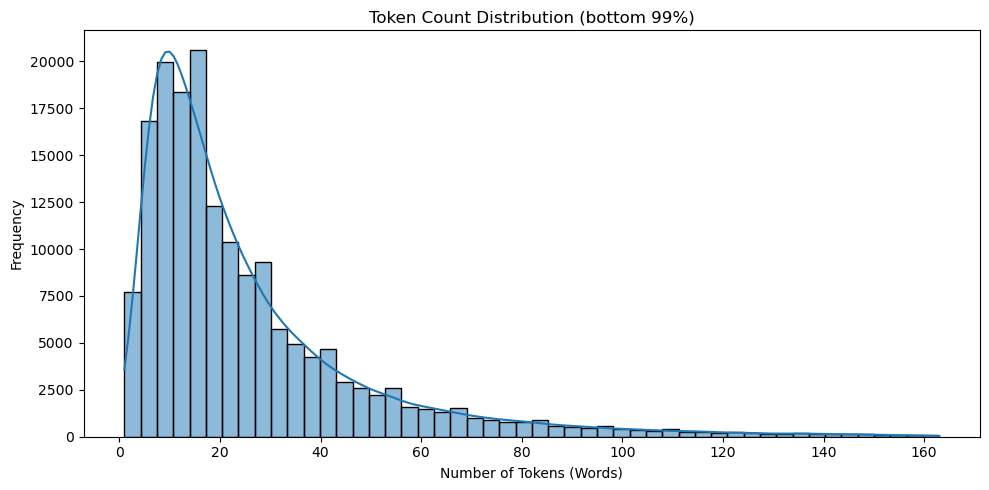

In [ ]:
df = pd.read_csv("data-processed/nlp-sentiment.csv")
df["char_length"] = df["text"].str.len()
df["token_count"] = df["text"].str.split().apply(len)

#to get rid of outliers (long articles)
#i filter out top 1 %
char_q = df["char_length"].quantile(0.99)
tok_q = df["token_count"].quantile(0.99)

df_filtered = df[(df["char_length"] <= char_q) & (df["token_count"] <= tok_q)]

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df_filtered["char_length"], bins=50, kde=True, ax=ax)
ax.set_title("Character Length Distribution (bottom 99%)")
ax.set_xlabel("Number of Characters")
ax.set_ylabel("Frequency")
plt.tight_layout()
fig.savefig("images/2-char-length-dist.png", dpi=300, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df_filtered["token_count"], bins=50, kde=True, ax=ax)
ax.set_title("Token Count Distribution (bottom 99%)")
ax.set_xlabel("Number of Tokens (Words)")
ax.set_ylabel("Frequency")
plt.tight_layout()
fig.savefig("images/3-token-count-dist.png", dpi=300, bbox_inches="tight")
plt.show()

## Most Frequent Named Entities

In [ ]:
df = pd.read_csv("data-processed/nlp-sentiment.csv")
df["entities"] = df["entities"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# each row for each entity
entity_df = df.explode("entities")

#top emtities count
top_entities = (
    entity_df["entities"]
    .str.lower()
    .value_counts()
    .head(20)
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=top_entities.values, y=top_entities.index, hue=top_entities.index, palette="viridis", ax=ax)
ax.set_title("Top 20 Mentioned GPU Models / Features")
ax.set_xlabel("Frequency")
ax.set_ylabel("Entity")
plt.tight_layout()
fig.savefig("images/4-top-mentioned.png", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\Matthew\AppData\Local\Temp\ipykernel_3364\1914643273.py:1: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data-processed/nlp-sentiment.csv")


## Word Clouds by Brand or Sentiment

In [ ]:
def make_wordcloud(text_series, title, filename):
    text_blob = " ".join(text_series.dropna().astype(str))
    wc = WordCloud(width=1200, height=400, background_color="white", colormap="icefire").generate(text_blob)
    fig = plt.figure(figsize=(20, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.tight_layout()
    fig.savefig(f"images/{filename}", dpi=300, bbox_inches="tight")
    plt.show()

make_wordcloud(df[df["sentiment_label"] == "positive"]["text"], "POSITIVE Comments",
               "5-wordcloud-positive.png")
make_wordcloud(df[df["sentiment_label"] == "negative"]["text"], "NEGATIVE Comments",
               "6-wordcloud-negative.png")

These 2 word clouds reveal a clear sentiment split: positive comments focus on gaming experience, performance, and excitement for new GPU models, while negative comments revolve around pricing frustration, stock issues, and perceived value failures. Both NVIDIA and AMD are frequently mentioned, but the tone around them shifts—positive mentions include terms like **“better”**, **“upgrade”**, **“great”**, while negative mentions are often tied to **“scam”**, **“pay”**, or **“problem”**.

Interestingly, the same products (e.g., **5070 Ti**, **9070 XT**) appear in both clouds, but are framed either with hopeful or critical language depending on the sentiment. This shows that user sentiment is driven less by specs and more by price, availability, and perceived fairness.

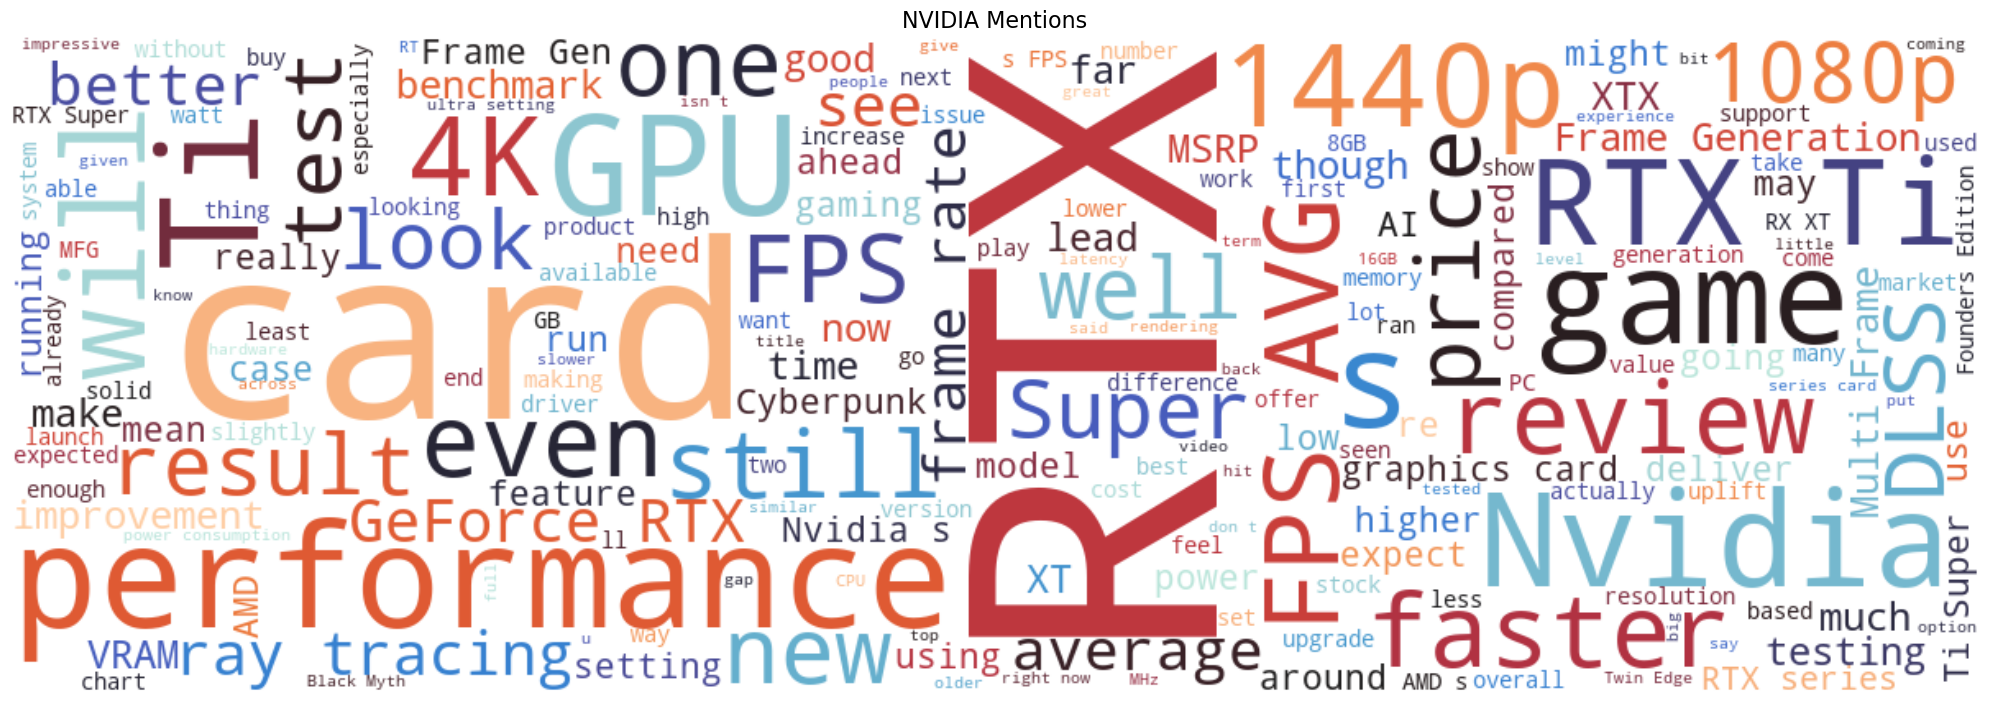

In [ ]:
make_wordcloud(df[df["brand"] == "NVIDIA"]["text"], "NVIDIA Mentions",
               "7-wordcloud-nvidia.png")

make_wordcloud(df[df["brand"] == "AMD"]["text"], "AMD Mentions",
               "8-wordcloud-amd.png")

NVIDIA-focused cloud dwells on raw **“performance”**, **“FPS”**, and being **“faster”**—with big emphasis on **ray tracing**, **DLSS**, **Frame Generation** and numeric metrics like **1080p** / **1440p** / **4K**. Words such as **“review”**, **“test”**, **“benchmark”** and **“average”** suggest audiences study graphs and data, and the word **“price”** is still prominent, indicating a thorough cost-benefit analysis even amidst the hype around speed.

AMD-focused comments highlight **“RX”**, **“XT”**, **“Radeon”**, and repeatedly pair them with **“price”**, **“budget”**, **“value”** and **“power”**—framing the brand as the cost-effective contender. Terms like **“slightly slower”**, **“catch-up”** and **“RDNA”** appear alongside **“lead”** and **“advantage”**, implying that users are discussing the difference in performance of each card.

# Inferential Analysis and Research Questions

## Overall Sentiment Landscape

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(data=df, x="sentiment_label", hue="sentiment_label",
                   order=["positive", "neutral", "negative"], palette="viridis")
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count:,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
fig.savefig("images/9-overall-sentiment-bar.png", dpi=300, bbox_inches="tight")
plt.show()

Public sentiment is clearly skewed **positive** (87k), but with a significant portion expressing **neutralitry** (44k) or **dissatisfaction** (44k).

This suggests an overall `favorable reception` to the new GPU generation — but not without criticism.

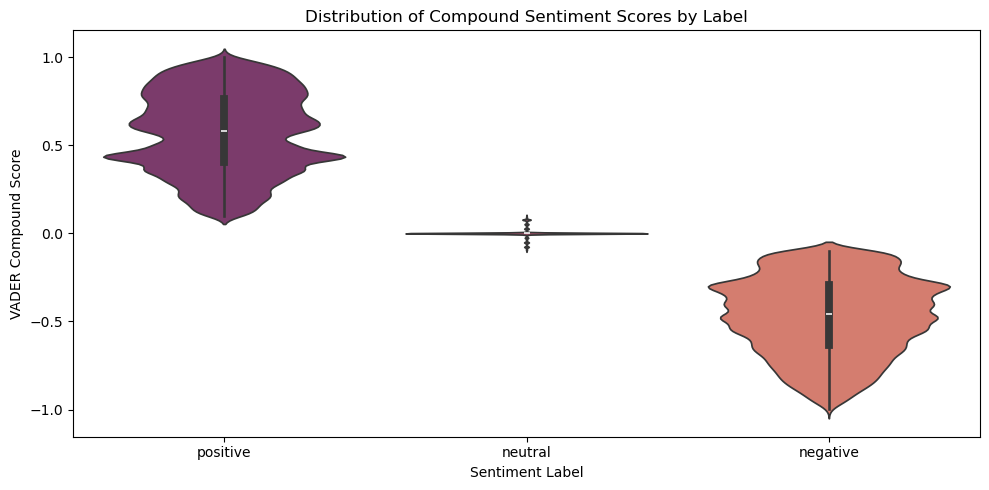

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(data=df, x="sentiment_label", y="sentiment_compound", hue="sentiment_label",
               order=["positive", "neutral", "negative"], palette="flare")
plt.title("Distribution of Compound Sentiment Scores by Label")
plt.xlabel("Sentiment Label")
plt.ylabel("VADER Compound Score")
plt.tight_layout()
fig.savefig("images/10-sentiment-compound-violin.png", dpi=300, bbox_inches="tight")
plt.show()

**Positive** and **negative** comments have well-separated score distributions, as expected.

**Neutral** scores cluster tightly around 0, confirming that the ±0.1 threshold effectively captured **ambiguity**.

The graph shows a strong polarity of users' opinions, with the groups of positive and negative users hardly overlapping.

## Brand-Level Sentiment Gap (NVIDIA vs AMD)

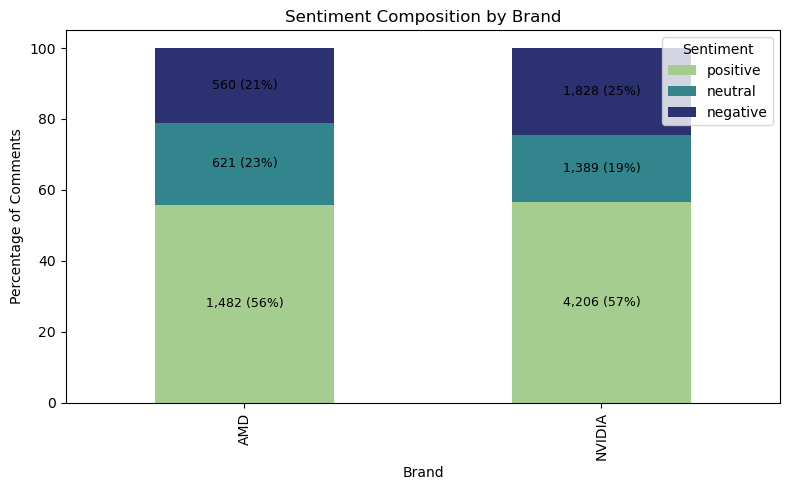

In [ ]:
df = pd.read_csv("data-processed/nlp-sentiment.csv", low_memory=False)

df["entities"] = df["entities"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

#ree-infer brand using entities
NVIDIA_HINTS = {"nvidia", "geforce", "rtx", "dlss", "reflex", "dldsr", "g-sync", "physx", "cuda"}
AMD_HINTS = {"amd", "radeon", "rx", "fsr", "fidelityfx"}

RX_RE = re.compile(r"\brx\d{3,4}\w*\b", re.I)
RTX_RE = re.compile(r"\brtx\d{3,4}\w*\b", re.I)

def infer_brand(entities):
    text = " ".join(entities).lower()
    if RTX_RE.search(text): return "NVIDIA"
    if RX_RE.search(text): return "AMD"
    if any(h in text for h in NVIDIA_HINTS): return "NVIDIA"
    if any(h in text for h in AMD_HINTS): return "AMD"
    return "general"

df["brand"] = df["entities"].apply(infer_brand)

df_brands = df[df["brand"].isin(["NVIDIA", "AMD"]) & df["sentiment_label"].notna()]

# %
crosstab = pd.crosstab(df_brands["brand"], df_brands["sentiment_label"], normalize='index') * 100
crosstab = crosstab[["positive", "neutral", "negative"]]  # ensure order

#counts
raw_counts = pd.crosstab(df_brands["brand"], df_brands["sentiment_label"])
raw_counts = raw_counts[["positive", "neutral", "negative"]]

fig, ax = plt.subplots(figsize=(8, 5))
crosstab.plot(kind="bar", stacked=True, colormap="crest", ax=ax)

ax.set_title("Sentiment Composition by Brand")
ax.set_ylabel("Percentage of Comments")
ax.set_xlabel("Brand")

for idx, brand in enumerate(crosstab.index):
    cumulative = 0
    for sentiment in ["positive", "neutral", "negative"]:
        count = raw_counts.loc[brand, sentiment]
        percent = crosstab.loc[brand, sentiment]
        ax.text(idx, cumulative + percent / 2, f"{count:,} ({percent:.0f}%)",
                ha="center", va="center", fontsize=9, color="black")
        cumulative += percent

ax.legend(title="Sentiment", loc="upper right")
plt.tight_layout()
fig.savefig("images/11-brand-sentiment-stacked-bar.png", dpi=300, bbox_inches="tight")
plt.show()

Both launches are talked about mostly in a **positive tone**: ≈ **57%** of NVIDIA comments and **56%** of AMD comments are classified as positive.

Neutral chat is higher for AMD (**23%** vs. **19%**), suggesting people are a bit more matter-of-fact when mentioning Radeon cards.

Negative share is slightly larger for NVIDIA (**25%** vs. **21%**), hinting at a touch more criticism or polarisation around the RTX 50-series.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(data=df_brands, x="brand", y="sentiment_compound", 
               hue="brand", palette="flare")
plt.title("Distribution of VADER Compound Scores by Brand")
plt.xlabel("Brand")
plt.ylabel("Compound Sentiment Score")
plt.tight_layout()
fig.savefig("images/12-sentiment-compound-violin.png", dpi=300, bbox_inches="tight")
plt.show()

The two violins overlap heavily and both are **skewed to the positive side** — the white median dot for NVIDIA sits a bit furhter right, confirming the marginally higher positivity seen above.

NVIDIA’s shape is a little **“fatter”** in both the high-positive and high-negative ends, matching the observation that it draws both **more good reviews and more criticism**.

AMD’s distribution is narrower around zero, consistent with its larger neutral slice.

## Feature-Level Sentiment Drivers (DLSS, FSR...)

*This code was partly generated and troubleshooted using Perplexity LLM due to its' complexity.

In [ ]:
df = pd.read_csv("data-processed/nlp-sentiment.csv", low_memory=False)
df["entities"] = df["entities"].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df["sentiment_label"] = df["sentiment_label"].fillna("neutral")

#all spelling variants into 1 label witrh regex
PATTERN_TO_LABEL = {
    r"\bdlss\s*4\b":          "DLSS 4",
    r"\bdlss\s*3\b":          "DLSS 3",
    r"\bdlss\s*2\b":          "DLSS 2",
    r"\bdlss\b":              "DLSS",
    r"\bfsr\s*4\b":           "FSR 4",
    r"\bfsr\s*3\b":           "FSR 3",
    r"\bfsr\s*2\b":           "FSR 2",
    r"\bfsr\b":               "FSR",
    r"frame\s*gen(eration)?": "Frame Gen",
    r"ray[-\s]?tracing":      "Ray Tracing",
}

def canonize(token: str) -> str | None:
    token = token.lower()
    for pattern, label in PATTERN_TO_LABEL.items():
        if re.search(pattern, token, flags=re.I):
            return label
    return None

# #we want to keep only feature-related entities
exploded = (df.explode("entities")
              .assign(feature=lambda d: d["entities"].astype(str).str.lower().apply(canonize))
              .dropna(subset=["feature"]))

# sentiment counts & ordering
sent_counts = (exploded.groupby(["feature", "sentiment_label"])
                        .size()
                        .unstack(fill_value=0)
                        .reindex(columns=["positive", "neutral", "negative"]))

#order index from row totals
row_order   = sent_counts.sum(axis=1).sort_values(ascending=False).index
sent_counts = sent_counts.loc[row_order]

sent_pct = sent_counts.div(sent_counts.sum(axis=1), axis=0).mul(100)

#horizontal stacked bars drawing
fig, ax = plt.subplots(figsize=(12, 6))
palette = ["#41ad6e", "#9a9a9a", "#bf2f2f"]
bottom = None
for col, colour in zip(sent_pct.columns, palette):
    ax.barh(sent_pct.index, sent_pct[col], left=bottom,
            color=colour, label=col, edgecolor="white")
    bottom = sent_pct[col] if bottom is None else bottom + sent_pct[col]
    ax.set_xlim(0, 110)

ax.set_xlabel("Share of mentions (%)")
ax.set_title("Sentiment toward Key GPU Features")
ax.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")

#net-sentiment values on each row
for y, feat in enumerate(sent_counts.index):
    pos, neu, neg = sent_counts.loc[feat, ["positive", "neutral", "negative"]]
    total = pos + neu + neg
    net   = pos - neg
    
    #total mentions centred inside the bar
    ax.text(50, y, f"{total:,}", ha="center", va="center",
            color="white", fontsize=10, fontweight="bold")
    
    # net sentiment on the right edge
    ax.text(101, y, f"net {net:+}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

Every feature on the chart shows `net-positive sentiment` (inasmuch as green area always larger than red), but the size of the conversation and the strength of the positivity vary a lot.  

Stand-outs by volume:
- **DLSS** (all versions combined) leads the discussion by a wide margin (≈4.2k mentions), followed by **Frame Generation** (≈3.3k) and **Ray Tracing** (≈2.9k).
- AMD’s flagship upscaler **FSR** gets roughly a third of DLSS volume (≈1.6k), while “versioned” variants such as FSR 4 and DLSS 4 still attract four-digit volumes despite being newer.  

To sum up, the community is overwhelmingly upbeat about modern upscaling and frame-generation features, with NVIDIA’s DLSS leading the conversation. Ray tracing remains popular yet polarising, while older upscaling versions have faded into niche discussion with modest, mostly positive sentiment. Personal note: "some people downplay the significance of this technology, attributing it to a significant drop in performance with little improvement in image quality, noticeable to either experts or veteran gamers."


## Mention Frequency & Usage Context

### Frequency of Mentions

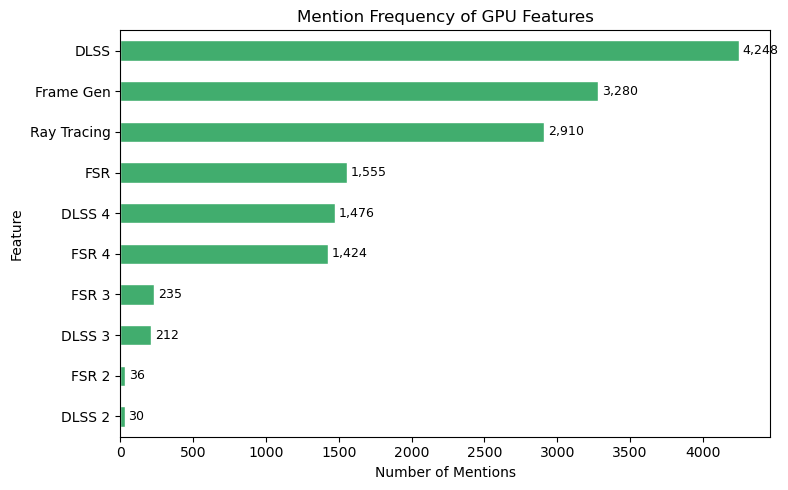

In [ ]:
feature_freq = exploded["feature"].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
feature_freq.plot(kind="barh", color="#41ad6e", edgecolor="white", ax=ax)

for i, (feature, count) in enumerate(feature_freq.items()):
    ax.text(count + 25, i, f"{count:,}", va="center", fontsize=9)

ax.set_title("Mention Frequency of GPU Features")
ax.set_xlabel("Number of Mentions")
ax.set_ylabel("Feature")

plt.tight_layout()
fig.savefig("images/14-feature-frequency-bar.png", dpi=300, bbox_inches="tight")
plt.show()

### Co-occurrence Heatmap of Entities

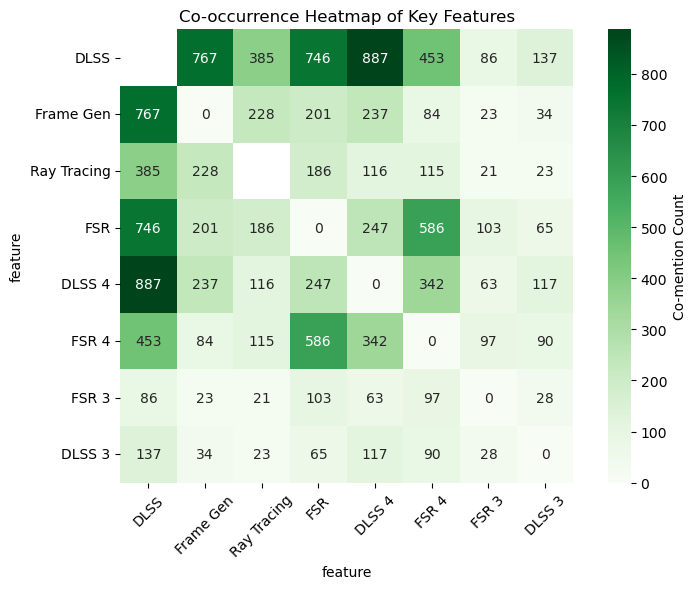

In [ ]:
df_feature_pairs = exploded.groupby(exploded.index)["feature"].apply(lambda x: sorted(set(x)))

pair_counter = Counter()
for features in df_feature_pairs[df_feature_pairs.apply(len) > 1]:
    for pair in combinations(features, 2):
        pair_counter[pair] += 1

co_df = pd.DataFrame(pair_counter.items(), columns=["pair", "count"])
co_df[["f1", "f2"]] = pd.DataFrame(co_df["pair"].tolist(), index=co_df.index)

#pivot to matrix
co_matrix = co_df.pivot_table(index="f1", columns="f2", values="count", fill_value=0)
co_matrix = co_matrix.add(co_matrix.T, fill_value=0)

top_features = exploded["feature"].value_counts().head(8).index
co_matrix = co_matrix.loc[top_features, top_features]

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(co_matrix, annot=True, fmt="g", cmap="Greens", square=True,
            cbar_kws={'label': 'Co-mention Count'}, ax=ax)

ax.set_title("Co-occurrence Heatmap of Key Features")
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)

plt.tight_layout()
fig.savefig("images/15-cooccurrence-heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

This heatmap above shows how often pairs of GPU technologies are mentioned in the same comment.  

1. DLSS and FSR co-occur frequently (746 mentions), reflecting direct comparisons between NVIDIA and AMD upscaling.
2. Frame Generation and DLSS (or DLSS 4) have strong overlaps (767 and 237 mentions, respectively), suggesting they're often discussed as complementary technologies.
3. FSR 4 co-occurs notably with both DLSS 4 and FSR, reinforcing that users compare generational and cross-brand features.
4. Lower counts in the DLSS 3 / FSR 3 rows suggest users focus more on the latest versions.

### Keyword-in-Context Snippets

In [ ]:
# thuis thing allows to show the context
# of a keyword in the text
def kwic_view(df, keyword, window=30, n=5):
    keyword = keyword.lower()
    matched = df[df["text"].str.contains(keyword, case=False, na=False)].sample(n=6, random_state=RANDOM_STATE)
    for i, text in enumerate(matched["text"]):
        idx = text.lower().find(keyword)
        if idx != -1:
            left = text[max(0, idx - window):idx]
            right = text[idx + len(keyword):idx + len(keyword) + window]
            print(f"{i+1}. ...{left}[{keyword}]{right}...\n")

#here lets see how the keyword DLSS appears in te comments
kwic_view(df, "DLSS", window=35, n=6)

1. ...recently discovered Nvidas DLDSR + [dlss] and this sh*t is awsome, what an i...

2. ...r 4k gaming. And sure, you can put [dlss] in performance and get the frames ...

3. ...itles start using AI for features. [dlss] and FG are already needed to hide ...

4. ...rong, like what literally typed in [dlss]3 vs fsr3 since "i need to do more ...

5. ... 3070 Ti is becoming depressing... [dlss] for the rest of its life apparentl...

6. ...s a must buy. A 4090 with improved [dlss]4 frame gen and being much more pow...



# Conclusion

In this project I analyzed public sentiment toward NVIDIA RTX 5000 Series and AMD RX 9000-Series GPU launches using YouTube comments and tech-news articles. I have thoroughly researched, analyzed, and addressed all four research questions.

After preprocessing and annotating **172362** texts with entity tags and VADER sentiment scores, the following has been found:
- Overall sentiment skewed **positive** across both brands.
- NVIDIA gained a slight advantage in strength and consistency of sentiment.
- DLSS, Frame Generation and FSR were the most frequently discussed features, often appearing together.
- Co-occurrence models showed meaningful clusters of comparison (e.g. DLSS + FSR, Ray Tracing + Frame Gen).
- Keyword-in-context snippets examples provided contextual insight into user reactions and phrasing.